# 2-D Cross-Section Meshing for Mode Analysis

This notebook demonstrates using `ModalSim` to slice a 3-D CPW (coplanar waveguide) geometry with a cutting plane and produce a 2-D triangular mesh. The resulting `.msh` file can be loaded into eigenmode solvers such as [femwell](https://github.com/HelgeGehwornis/femwell).

**Requirements:**

- IHP PDK: `uv pip install ihp-gdsfactory`

### Load a pcell from IHP PDK

2026-02-23 17:41:05.332 | WARNING  | doroutes.pcells:<module>:25 - Cannot determine output type ((D)KCell type)from annotation <class 'kfactory.kcell.DKCell'>. Trying to continue but likely this will fail.
2026-02-23 17:41:05.335 | WARNING  | doroutes.pcells:<module>:48 - Cannot determine output type ((D)KCell type)from annotation <class 'kfactory.kcell.DKCell'>. Trying to continue but likely this will fail.
2026-02-23 17:41:05.336 | WARNING  | doroutes.pcells:<module>:110 - Cannot determine output type ((D)KCell type)from annotation <class 'kfactory.kcell.DKCell'>. Trying to continue but likely this will fail.
2026-02-23 17:41:05.337 | WARNING  | doroutes.pcells:<module>:149 - Cannot determine output type ((D)KCell type)from annotation <class 'kfactory.kcell.DKCell'>. Trying to continue but likely this will fail.
2026-02-23 17:41:05.338 | WARNING  | doroutes.pcells:<module>:168 - Cannot determine output type ((D)KCell type)from annotation <class 'kfactory.kcell.DKCell'>. Trying to con

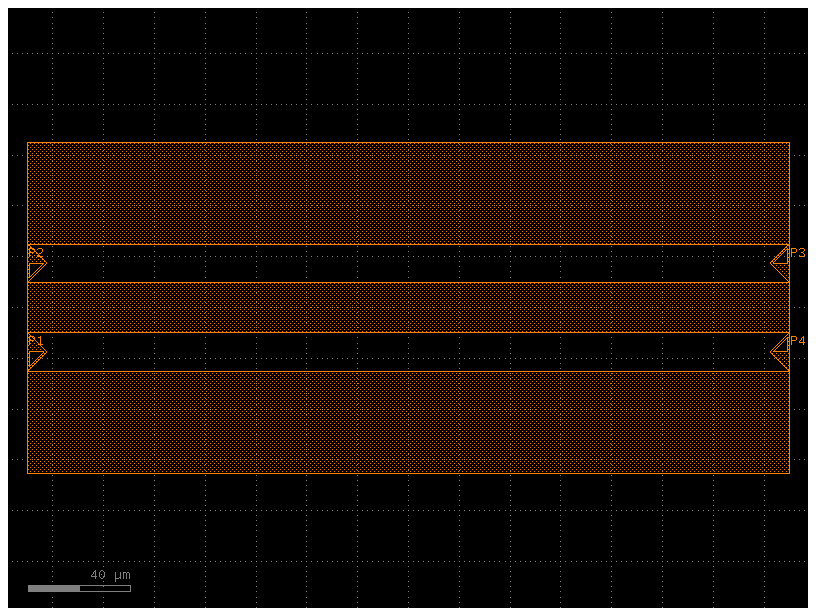

In [1]:
import gdsfactory as gf
from ihp import LAYER, PDK

PDK.activate()


@gf.cell
def gsg_electrode(
    length: float = 300,
    s_width: float = 20,
    g_width: float = 40,
    gap_width: float = 15,
    layer=LAYER.TopMetal2drawing,
) -> gf.Component:
    """
    Create a GSG (Ground-Signal-Ground) electrode.

    Args:
        length: horizontal length of the electrodes
        s_width: width of the signal (center) electrode
        g_width: width of the ground electrodes
        gap_width: gap between signal and ground electrodes
        layer: layer for the metal
    """
    c = gf.Component()

    # Top ground electrode
    r1 = c << gf.c.rectangle((length, g_width), centered=True, layer=layer)
    r1.move((0, (g_width + s_width) / 2 + gap_width))

    # Center signal electrode
    _r2 = c << gf.c.rectangle((length, s_width), centered=True, layer=layer)

    # Bottom ground electrode
    r3 = c << gf.c.rectangle((length, g_width), centered=True, layer=layer)
    r3.move((0, -(g_width + s_width) / 2 - gap_width))

    # Add ports at the gaps
    c.add_port(
        name="P1",
        center=(-length / 2, -(s_width + gap_width) / 2),
        width=gap_width,
        orientation=0,
        port_type="electrical",
        layer=layer,
    )

    c.add_port(
        name="P2",
        center=(-length / 2, (s_width + gap_width) / 2),
        width=gap_width,
        orientation=0,
        port_type="electrical",
        layer=layer,
    )

    c.add_port(
        name="P3",
        center=(length / 2, (s_width + gap_width) / 2),
        width=gap_width,
        orientation=180,
        port_type="electrical",
        layer=layer,
    )

    c.add_port(
        name="P4",
        center=(length / 2, -(s_width + gap_width) / 2),
        width=gap_width,
        orientation=180,
        port_type="electrical",
        layer=layer,
    )

    return c


c = gsg_electrode()
cc = c.copy()
cc.draw_ports()
cc

### Configure 2-D cross-section with ModalSim

In [2]:
from gsim.palace import ModalSim

# Create modal simulation object
sim = ModalSim()

# Set output directory
sim.set_output_dir("./modal-sim-cpw")

# Set the component geometry
sim.set_geometry(c)

# Configure layer stack from active PDK
sim.set_stack(substrate_thickness=2.0, air_above=300.0)

# Define a cutting plane at y = 0 (XZ cross-section through the centre)
sim.set_cross_section(x=0.0)

# Validate configuration
print(sim.validate_config())

Validation: PASSED


In [3]:
# Generate the 2-D cross-section mesh
sim.mesh(preset="default")

  'air' → surfaces [50]
  'passive' → surfaces [59]
  'SiO2' → surfaces [75]
  'airbox' → surfaces [101]
  Physical 'air' (dim=2): pg=8, tags=[50]
  Physical 'passive' (dim=2): pg=9, tags=[59]
  Physical 'SiO2' (dim=2): pg=10, tags=[75]
  Physical 'airbox' (dim=2): pg=11, tags=[101]
  Physical 'air__airbox' (dim=1): pg=12, tags=[86, 91, 89]
  Physical 'air__passive' (dim=1): pg=13, tags=[92]
  Physical 'airbox__passive' (dim=1): pg=14, tags=[102, 98, 108, 105, 104, 101]
  Physical 'SiO2__passive' (dim=1): pg=15, tags=[115, 113, 111, 109]
  Physical 'passive__None' (dim=1): pg=16, tags=[114, 112, 110]
  Physical 'SiO2__airbox' (dim=1): pg=17, tags=[135, 138, 137]
  Physical 'SiO2__None' (dim=1): pg=18, tags=[147, 146, 145, 144, 143, 142, 141, 140, 139]
  Physical 'airbox__None' (dim=1): pg=19, tags=[163, 169, 168, 166]


Mesh Summary
Dimensions: 500.0 x 1800.0 x 1800.0 µm
Nodes:      278
Elements:   1,049
----------------------------------------
Surfaces (4):
  - air [8]
  - passive [9]
  - SiO2 [10]
  - airbox [11]
----------------------------------------
Mesh:   modal-sim-cpw/palace.msh

/home/martin/Desktop/gsim/src/gsim/viz.py:275: UserWarning: Failed to use notebook backend: 

No module named 'trame.app'

Falling back to a static output.
  plotter.show()


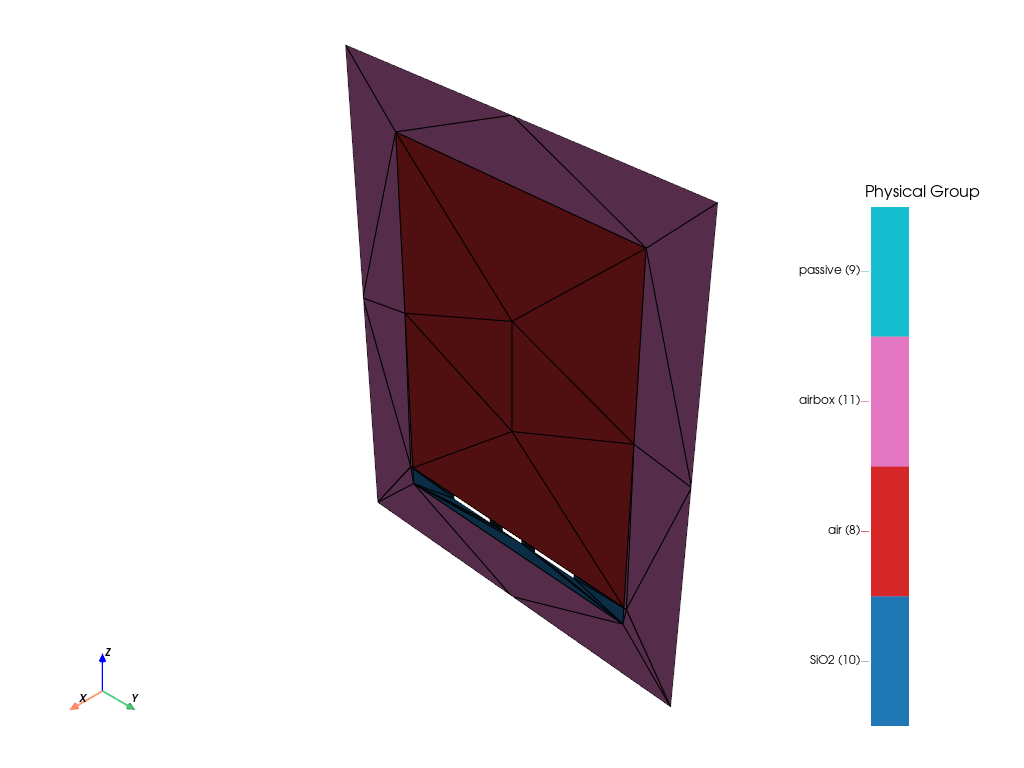

In [4]:
# Plot the 2-D cross-section mesh
sim.plot_mesh(show_groups=["passive", "SiO2"], style="solid", interactive=True)

### Load the mesh in femwell

The generated `.msh` file lives in a YZ-plane (all x = 0).  Two adjustments are
needed before femwell can use it:

1. **Drop the constant x-coordinate** — `from_meshio` would otherwise create a
   degenerate 2-D mesh with one dimension equal to zero.
2. **Fill conductor voids** — the IHP PDK models metals as volumes but the
   cross-section mesher leaves them as unmeshed holes.  We detect the void
   rectangles from the `__None` boundary edges, triangulate them, and insert
   them as `"aluminum"` subdomains.

In [9]:
import meshio
import numpy as np
from collections import defaultdict
from scipy.constants import epsilon_0, speed_of_light
from scipy.spatial import Delaunay
from skfem import Basis, ElementTriP0
from skfem.io.meshio import from_meshio

from gsim.common.stack.materials import MATERIALS_DB, get_material_properties

# ------------------------------------------------------------------
# 1. Read the raw meshio object and fix coordinates (YZ → XY)
# ------------------------------------------------------------------
msh = meshio.read("./modal-sim-cpw/palace.msh")

# The mesh sits in the YZ-plane (all x ≡ 0).  Drop x so that
# from_meshio gets a proper 2-D point cloud.
msh.points = msh.points[:, 1:]  # (N, 3) → (N, 2)  keeping (y, z)

# ------------------------------------------------------------------
# 2. Detect conductor voids from "__None" boundary edges
# ------------------------------------------------------------------
# Edges whose physical-group name contains "__None" border an unmeshed
# conductor region.  We collect the NON-None side of each edge to know
# which material name contributed the boundary, but we don't need it
# for the fill — all voids here are aluminum (TopMetal2).

line_cells = msh.cells[0]  # CellBlock of type "line"
line_phys = msh.cell_data["gmsh:physical"][0]
tag_to_name = {tag: name for name, (tag, dim) in msh.field_data.items() if dim == 1}

# Gather point indices that sit on void boundaries (excluding airbox__None)
void_pt_indices = set()
for idx, tag in enumerate(line_phys):
    name = tag_to_name.get(tag, "")
    if "__None" in name and "airbox" not in name:
        seg = line_cells.data[idx]
        void_pt_indices.update(seg)

void_pts = msh.points[list(void_pt_indices)]  # (M, 2) in (y, z)
print(f"Void boundary points: {len(void_pts)}")

# Find distinct rectangular voids by clustering the y-coordinate
void_y = np.sort(np.unique(np.round(void_pts[:, 0], 6)))
print(f"Unique void y-coords: {void_y}")

# Each conductor void is a rectangle; extract [y_min, y_max, z_min, z_max]
voids = []
visited = set()
for y_val in void_y:
    if y_val in visited:
        continue
    # Points at this y
    mask = np.abs(void_pts[:, 0] - y_val) < 1e-4
    z_at_y = void_pts[mask, 1]
    z_min, z_max = z_at_y.min(), z_at_y.max()
    # Find the matching y on the other side of the rectangle
    for y2 in void_y:
        if y2 <= y_val:
            continue
        mask2 = np.abs(void_pts[:, 0] - y2) < 1e-4
        z_at_y2 = void_pts[mask2, 1]
        if np.isclose(z_at_y2.min(), z_min) and np.isclose(z_at_y2.max(), z_max):
            # Check if there are no void_y values strictly between y_val and y2
            between = [y for y in void_y if y_val < y < y2]
            if len(between) == 0:
                voids.append((y_val, y2, z_min, z_max))
                visited.add(y_val)
                visited.add(y2)
                break

print(f"\nDetected {len(voids)} conductor void(s):")
for i, (y0, y1, z0, z1) in enumerate(voids):
    print(f"  Void {i}: y ∈ [{y0:.2f}, {y1:.2f}], z ∈ [{z0:.2f}, {z1:.2f}]")

# ------------------------------------------------------------------
# 3. Triangulate each void and merge into the meshio object
# ------------------------------------------------------------------
existing_pts = list(msh.points)  # list of (y, z) arrays
existing_tris = list(msh.cells[1].data)  # existing triangle connectivity
existing_tri_phys = list(msh.cell_data["gmsh:physical"][1])

# Determine a new physical tag for "aluminum"
used_tags = {tag for name, (tag, dim) in msh.field_data.items()}
al_tag = max(used_tags) + 1
msh.field_data["aluminum"] = np.array([al_tag, 2])

pt_map = {}  # (y_rounded, z_rounded) → global index
for gi, pt in enumerate(existing_pts):
    key = (round(pt[0], 6), round(pt[1], 6))
    pt_map[key] = gi

n_pts_before = len(existing_pts)

for y0, y1, z0, z1 in voids:
    # Rectangle corners (may already exist in the mesh)
    corners = [(y0, z0), (y0, z1), (y1, z0), (y1, z1)]
    corner_ids = []
    for c in corners:
        key = (round(c[0], 6), round(c[1], 6))
        if key not in pt_map:
            pt_map[key] = len(existing_pts)
            existing_pts.append(np.array(c))
        corner_ids.append(pt_map[key])

    # Also add any existing void boundary points that sit on the rectangle edges
    rect_pt_ids = set(corner_ids)
    for gi in void_pt_indices:
        py, pz = round(msh.points[gi, 0], 6), round(msh.points[gi, 1], 6)
        if (y0 - 1e-4 <= py <= y1 + 1e-4) and (z0 - 1e-4 <= pz <= z1 + 1e-4):
            rect_pt_ids.add(gi)

    # Triangulate the rectangle using its boundary points
    rect_pt_list = sorted(rect_pt_ids)
    local_coords = np.array([existing_pts[gi] for gi in rect_pt_list])
    tri = Delaunay(local_coords)

    for simplex in tri.simplices:
        global_tri = [rect_pt_list[s] for s in simplex]
        existing_tris.append(global_tri)
        existing_tri_phys.append(al_tag)

# Rebuild the meshio object
new_points = np.array(existing_pts)
new_tri_data = np.array(existing_tris)
new_line_data = msh.cells[0].data  # lines unchanged

new_cells = [
    meshio.CellBlock("line", new_line_data),
    meshio.CellBlock("triangle", new_tri_data),
]
new_cell_data = {
    "gmsh:physical": [
        msh.cell_data["gmsh:physical"][0],  # line tags unchanged
        np.array(existing_tri_phys),
    ],
    "gmsh:geometrical": [
        msh.cell_data["gmsh:geometrical"][0],
        np.concatenate([
            msh.cell_data["gmsh:geometrical"][1],
            np.full(len(existing_tri_phys) - len(msh.cell_data["gmsh:geometrical"][1]), al_tag),
        ]),
    ],
}

msh_filled = meshio.Mesh(
    points=new_points,
    cells=new_cells,
    cell_data=new_cell_data,
    field_data={**msh.field_data},
)

# ------------------------------------------------------------------
# 4. Load into skfem
# ------------------------------------------------------------------
mesh = from_meshio(msh_filled)

print(f"\nFinal mesh:")
print(f"  Elements : {mesh.nelements}")
print(f"  Nodes    : {mesh.nnodes}")
print(f"  Subdomains: {sorted(mesh.subdomains.keys())}")
print(f"  Boundaries: {sorted(mesh.boundaries.keys())}")


Void boundary points: 12
Unique void y-coords: [-65. -25. -10.  10.  25.  65.]

Detected 3 conductor void(s):
  Void 0: y ∈ [-65.00, -25.00], z ∈ [11.19, 14.19]
  Void 1: y ∈ [-10.00, 10.00], z ∈ [11.19, 14.19]
  Void 2: y ∈ [25.00, 65.00], z ∈ [11.19, 14.19]

Final mesh:
  Elements : 62
  Nodes    : 3
  Subdomains: ['SiO2', 'air', 'airbox', 'aluminum', 'passive']
  Boundaries: ['airbox__None']


### Assign material permittivities

Each 2-D subdomain is named after the material it came from (e.g. `"aluminum"`,
`"SiO2"`, `"air"`).  We look up ε_r and σ from `gsim`'s `MATERIALS_DB` and
build a complex-valued permittivity array:

$$
\varepsilon = \varepsilon_r - j\,\frac{\sigma}{\omega\,\varepsilon_0}
$$

In [6]:
# Choose analysis frequency
freq_ghz = 10.0  # GHz
freq = freq_ghz * 1e9  # Hz
omega = 2 * np.pi * freq
wavelength_um = (speed_of_light / freq) * 1e6  # convert m → µm (mesh is in µm)

print(f"Frequency  : {freq_ghz} GHz")
print(f"Wavelength : {wavelength_um:.1f} µm")

# Build ε(x,y) on a piecewise-constant (P0) basis
basis0 = Basis(mesh, ElementTriP0(), intorder=4)
epsilon = basis0.ones(dtype=complex)

for subdomain in mesh.subdomains:
    mat = get_material_properties(subdomain)
    if mat is None:
        print(f"  ⚠ '{subdomain}': not in MATERIALS_DB – leaving ε = 1")
        continue

    eps_r = mat.permittivity if mat.permittivity is not None else 1.0
    sigma = mat.conductivity if mat.conductivity is not None else 0.0

    eps_complex = eps_r - 1j * sigma / (omega * epsilon_0)

    dofs = basis0.get_dofs(elements=subdomain)
    epsilon[dofs] = eps_complex

    if sigma > 0:
        print(f"  '{subdomain}': ε_r={eps_r}, σ={sigma:.2e} S/m → ε = {eps_complex.real:.1f} - j{-eps_complex.imag:.2e}")
    else:
        print(f"  '{subdomain}': ε_r={eps_r}")

Frequency  : 10.0 GHz
Wavelength : 29979.2 µm
  'air': ε_r=1.0
  'passive': ε_r=6.6
  'SiO2': ε_r=4.1
  ⚠ 'airbox': not in MATERIALS_DB – leaving ε = 1


/home/martin/Desktop/gsim/.venv/lib/python3.12/site-packages/skfem/mapping/mapping_affine.py:107: RuntimeWarning: divide by zero encountered in divide
  self._invA[0, 0] =  self.A[1, 1] / self.detA  # noqa
/home/martin/Desktop/gsim/.venv/lib/python3.12/site-packages/skfem/mapping/mapping_affine.py:107: RuntimeWarning: invalid value encountered in divide
  self._invA[0, 0] =  self.A[1, 1] / self.detA  # noqa
/home/martin/Desktop/gsim/.venv/lib/python3.12/site-packages/skfem/mapping/mapping_affine.py:108: RuntimeWarning: invalid value encountered in divide
  self._invA[0, 1] = -self.A[0, 1] / self.detA
/home/martin/Desktop/gsim/.venv/lib/python3.12/site-packages/skfem/mapping/mapping_affine.py:109: RuntimeWarning: divide by zero encountered in divide
  self._invA[1, 0] = -self.A[1, 0] / self.detA
/home/martin/Desktop/gsim/.venv/lib/python3.12/site-packages/skfem/mapping/mapping_affine.py:109: RuntimeWarning: invalid value encountered in divide
  self._invA[1, 0] = -self.A[1, 0] / self.de

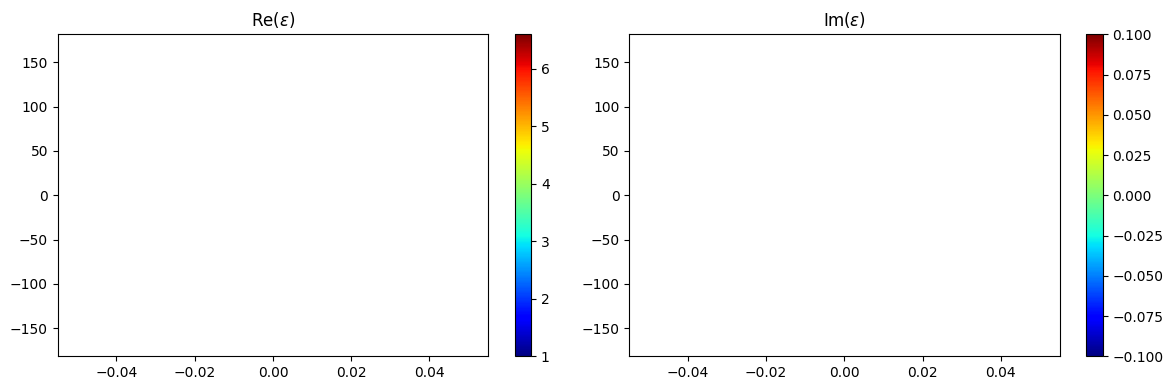

In [7]:
# Visualise the real and imaginary parts of ε(x,y)
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

ax = axes[0]
basis0.plot(epsilon.real, colorbar=True, ax=ax)
ax.set_title(r"Re($\varepsilon$)")
ax.set_axis_on()

ax = axes[1]
basis0.plot(epsilon.imag, colorbar=True, ax=ax)
ax.set_title(r"Im($\varepsilon$)")
ax.set_axis_on()

fig.tight_layout()
plt.show()

### Compute eigenmodes

We use `femwell.maxwell.waveguide.compute_modes` to solve for the propagating
modes.  For a CPW with GSG geometry we expect two modes (even and odd); setting
`num_modes=2` captures both.

In [8]:
import time

from femwell.maxwell.waveguide import compute_modes

num_modes = 2

start = time.time()
modes = compute_modes(
    basis0,
    epsilon,
    wavelength=wavelength_um,
    num_modes=num_modes,
    metallic_boundaries=False,
)
elapsed = time.time() - start

# Sort by effective index (ascending: odd mode first, even mode second)
modes = modes.sorted(key=lambda mode: mode.n_eff.real)

print(f"Solve time: {elapsed:.1f} s")
print(f"n_eff (real)       : {modes.n_effs.real}")
print(f"n_eff (imag)       : {modes.n_effs.imag}")

# Attenuation in dB/cm
atten_dB_cm = (
    20 / np.log(10) * modes.n_effs.imag * 2 * np.pi * freq / speed_of_light * 1e-2
)
print(f"Attenuation (dB/cm): {atten_dB_cm}")

/home/martin/Desktop/gsim/.venv/lib/python3.12/site-packages/skfem/element/element_hcurl.py:54: RuntimeWarning: divide by zero encountered in divide
  curl=dphi / detDF * orient[:, None],
/home/martin/Desktop/gsim/.venv/lib/python3.12/site-packages/femwell/maxwell/waveguide.py:544: RuntimeWarning: invalid value encountered in multiply
  1 / mu_r * curl(e_t) * curl(v_t) / k0**2


RuntimeError: Factor is exactly singular

### Visualise mode profiles

Plot the transverse electric and magnetic field intensity for each mode.

In [ ]:
from matplotlib.gridspec import GridSpec
from skfem import ElementDG, ElementTriP1, ElementVector

Nx, Ny = 80, 60
grid_data_E = np.zeros((num_modes, Ny, Nx, 3), dtype=complex)
grid_data_H = np.zeros((num_modes, Ny, Nx, 3), dtype=complex)

# Determine plot bounds from mesh (with a small margin)
x_all = mesh.p[0]
y_all = mesh.p[1]
xmin, xmax = x_all.min() * 0.5, x_all.max() * 0.5  # zoom to centre
ymin, ymax = y_all.min() * 0.3, y_all.max() * 0.05

grid_x, grid_y = np.meshgrid(
    np.linspace(xmin, xmax, Nx),
    np.linspace(ymin, ymax, Ny),
)

for i, mode in enumerate(modes):
    basis = mode.basis
    basis_fix = basis.with_element(ElementVector(ElementDG(ElementTriP1())))

    # Electric field
    (et, et_basis), (ez, ez_basis) = basis.split(mode.E)
    (et_x, et_x_basis), (et_y, et_y_basis) = basis_fix.split(
        basis_fix.project(et_basis.interpolate(et))
    )
    coords = np.array([grid_x.flatten(), grid_y.flatten()])
    grid_data_E[i] = np.array((
        et_x_basis.interpolator(et_x)(coords),
        et_y_basis.interpolator(et_y)(coords),
        ez_basis.interpolator(ez)(coords),
    )).T.reshape((*grid_x.shape, -1))

    # Magnetic field
    (ht, ht_basis), (hz, hz_basis) = basis.split(mode.H)
    (ht_x, ht_x_basis), (ht_y, ht_y_basis) = basis_fix.split(
        basis_fix.project(ht_basis.interpolate(ht))
    )
    grid_data_H[i] = np.array((
        ht_x_basis.interpolator(ht_x)(coords),
        ht_y_basis.interpolator(ht_y)(coords),
        hz_basis.interpolator(hz)(coords),
    )).T.reshape((*grid_x.shape, -1))

# Plot
fig = plt.figure(figsize=(12, 8))
gs = GridSpec(2, num_modes)

for i in range(num_modes):
    for row, data, field in [(0, grid_data_E[i], "E"), (1, grid_data_H[i], "H")]:
        ax = fig.add_subplot(gs[row, i])
        intensity = np.sqrt(np.sum(np.abs(data) ** 2, axis=2))
        ax.imshow(
            intensity,
            origin="lower",
            extent=[xmin, xmax, ymin, ymax],
            cmap="inferno",
            interpolation="bicubic",
            aspect="auto",
        )
        ax.streamplot(
            grid_x, grid_y,
            data.real[:, :, 0], data.real[:, :, 1],
            color="white", linewidth=0.4, density=1.5,
        )
        n_eff_str = f"{modes[i].n_eff.real:.4f}"
        ax.set_title(f"Mode {i} | $|{field}(x,y)|$   ($n_{{eff}}$={n_eff_str})")
        ax.set_xlabel("x (µm)")
        ax.set_ylabel("y (µm)")

fig.tight_layout()
plt.show()

### Transmission-line characterisation

Following the waveguide circuit theory of Marks & Williams (1992), we extract
the characteristic impedance $Z_0$ from the PI model:

$$
Z_0 = \frac{p_0}{|i_0|^2}, \qquad
i_0 = \oint_C \mathbf{h}_t \cdot d\ell, \qquad
p_0 = \int_S \mathbf{e}_t \times \mathbf{h}_t^* \, dS
$$

We also extract the per-unit-length RLGC parameters analytically from the field
integrals.

In [ ]:
from scipy.constants import mu_0

from femwell.maxwell.waveguide import calculate_scalar_product
from skfem import Functional
from skfem.helpers import inner

# --- Impedance via PI model ---
mode = modes[0]  # fundamental (even / GSG) mode

# Power integral  p₀ = ∫ e_t × h_t* dS
p0 = calculate_scalar_product(
    mode.basis, np.conjugate(mode.E),
    mode.basis, np.conjugate(mode.H),
)

# We need an integration contour around the signal conductor.
# The 1-D boundary groups created by ModalSim's slice_with_plane are labelled
# as "matA__matB".  Find boundaries touching a conductor subdomain.
conductor_boundaries = [
    name for name in mesh.boundaries
    if any(
        get_material_properties(part) is not None
        and get_material_properties(part).type == "conductor"
        for part in name.split("__")
        if part != "None"
    )
]
print(f"Conductor boundaries: {conductor_boundaries}")

# Integrate H around ALL conductor-touching boundaries to get total current
@Functional(dtype=np.complex64)
def current_form(w):
    return inner(np.array([w.n[1], -w.n[0]]), w.H)

(ht, ht_basis), (hz, hz_basis) = mode.basis.split(mode.H)

# Sum current contributions from each conductor boundary segment
i0 = 0.0 + 0j
for bnd_name in conductor_boundaries:
    if bnd_name not in mesh.boundaries:
        continue
    facet_basis = ht_basis.boundary(facets=mesh.boundaries[bnd_name])
    i0 += current_form.assemble(facet_basis, H=facet_basis.interpolate(ht))

print(f"|i₀| = {np.abs(i0):.6f}")
print(f"|p₀| = {np.abs(p0):.6f}")

# PI model impedance
z0_pi = p0 / np.abs(i0) ** 2
print(f"\nPI model: |Z₀| = {np.abs(z0_pi):.2f} Ω,  ∠Z₀ = {np.angle(z0_pi)/np.pi:.4f}π rad")

### RLGC parameters

Extract the per-unit-length resistance, inductance, conductance, and capacitance
from the mode fields.  The length unit of the mesh is **µm**, so we scale the
physical constants accordingly.

In [ ]:
# Define voltage from power: v₀ = p₀ / i₀*
v0 = p0 / i0.conj()

# Scale constants to µm (mesh length unit)
e0_um = epsilon_0 * 1e-6   # F/µm
mu0_um = mu_0 * 1e-6       # H/µm
omega_val = omega            # rad/s  (stays in SI)

(et, et_basis), (ez, ez_basis) = mode.basis.split(mode.E)

@Functional(dtype=np.complex64)
def C_form(w):
    return (1 / np.abs(w.v0) ** 2) * (
        np.real(w.epsilon) * inner(w.et, np.conj(w.et))
        - np.real(w.mu) * inner(w.hz, np.conj(w.hz))
    )

@Functional(dtype=np.complex64)
def L_form(w):
    return (1 / np.abs(w.i0) ** 2) * (
        np.real(w.mu) * inner(w.ht, np.conj(w.ht))
        - np.real(w.epsilon) * inner(w.ez, np.conj(w.ez))
    )

@Functional(dtype=np.complex64)
def G_form(w):
    return (-w.omega / np.abs(w.v0) ** 2) * (
        np.imag(w.epsilon) * inner(w.et, np.conj(w.et))
        + np.imag(w.mu) * inner(w.hz, np.conj(w.hz))
    )

@Functional(dtype=np.complex64)
def R_form(w):
    return (-w.omega / np.abs(w.i0) ** 2) * (
        np.imag(w.epsilon) * inner(w.ez, np.conj(w.ez))
        + np.imag(w.mu) * inner(w.ht, np.conj(w.ht))
    )

basis_eps = basis0
common_kwargs = dict(
    epsilon=basis_eps.interpolate(epsilon * e0_um),
    mu=mu0_um,
    i0=i0,
    omega=omega_val,
    v0=v0,
    et=et_basis.interpolate(et),
    ez=ez_basis.interpolate(ez),
    ht=ht_basis.interpolate(ht),
    hz=hz_basis.interpolate(hz),
)

C_val = C_form.assemble(mode.basis, **common_kwargs)
L_val = L_form.assemble(mode.basis, **common_kwargs)
G_val = G_form.assemble(mode.basis, **common_kwargs)
R_val = R_form.assemble(mode.basis, **common_kwargs)

Z0_rlgc = np.sqrt((R_val + 1j * omega_val * L_val) / (G_val + 1j * omega_val * C_val))
gamma = np.sqrt((R_val + 1j * omega_val * L_val) * (G_val + 1j * omega_val * C_val))

print("========== Impedance ==========")
print(f"PI model : |Z₀| = {np.abs(z0_pi):.2f} Ω")
print(f"RLGC     : |Z₀| = {np.abs(Z0_rlgc):.2f} Ω")

print("\n========== RLGC (per µm) ==========")
print(f"R = {R_val.real / 1e-3:.2f} mΩ/µm")
print(f"L = {L_val.real / 1e-12:.2f} pH/µm")
print(f"G = {G_val.real / 1e-12:.2f} pS/µm")
print(f"C = {C_val.real / 1e-15:.2f} fF/µm")

print("\n========== Propagation constant ==========")
print(f"β : RLGC = {gamma.imag * 1e6:.2f} 1/m  |  FEM = {mode.k.real * 1e6:.2f} 1/m")
print(f"α : RLGC = {gamma.real * 1e6:.2f} 1/m  |  FEM = {-mode.k.imag * 1e6:.2f} 1/m")

### Frequency sweep

Sweep over a range of frequencies to observe the dispersion of the microwave
index and attenuation.  The mesh is re-used – only ε(x,y) changes with frequency
(through the metal's complex permittivity).

In [ ]:
freqs_ghz = np.logspace(np.log10(1), np.log10(50), 15)  # 1–50 GHz, 15 points

neff_sweep = np.zeros(len(freqs_ghz), dtype=complex)
atten_sweep = np.zeros(len(freqs_ghz))
z0_sweep = np.zeros(len(freqs_ghz), dtype=complex)

# Identify conductor and dielectric subdomains once
subdomain_info = {}
for sd in mesh.subdomains:
    mat = get_material_properties(sd)
    if mat is not None:
        subdomain_info[sd] = mat

for idx, f_ghz in enumerate(freqs_ghz):
    f_hz = f_ghz * 1e9
    w = 2 * np.pi * f_hz
    lam_um = (speed_of_light / f_hz) * 1e6

    # Rebuild epsilon for this frequency
    eps = basis0.ones(dtype=complex)
    for sd, mat in subdomain_info.items():
        eps_r = mat.permittivity if mat.permittivity is not None else 1.0
        sigma = mat.conductivity if mat.conductivity is not None else 0.0
        eps[basis0.get_dofs(elements=sd)] = eps_r - 1j * sigma / (w * epsilon_0)

    ms = compute_modes(basis0, eps, wavelength=lam_um, num_modes=1, metallic_boundaries=False)

    neff_sweep[idx] = ms.n_effs[0]
    atten_sweep[idx] = (
        20 / np.log(10) * ms.n_effs[0].imag * 2 * np.pi * f_hz / speed_of_light * 1e-2
    )

    # Quick PI impedance
    m = ms[0]
    p = calculate_scalar_product(
        m.basis, np.conjugate(m.E), m.basis, np.conjugate(m.H)
    )
    (ht_, ht_b), _ = m.basis.split(m.H)
    i_ = 0.0 + 0j
    for bname in conductor_boundaries:
        if bname in mesh.boundaries:
            fb = ht_b.boundary(facets=mesh.boundaries[bname])
            i_ += current_form.assemble(fb, H=fb.interpolate(ht_))
    z0_sweep[idx] = p / np.abs(i_) ** 2

    print(f"  {f_ghz:6.2f} GHz  →  n_eff = {neff_sweep[idx].real:.4f},  "
          f"α = {atten_sweep[idx]:.2f} dB/cm,  |Z₀| = {np.abs(z0_sweep[idx]):.1f} Ω")

print("\nDone.")

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Microwave index
ax = axes[0]
ax.plot(freqs_ghz, neff_sweep.real, "o-", color="tab:blue")
ax.set_xlabel("Frequency (GHz)")
ax.set_ylabel("Microwave index  $n_{eff}$")
ax.set_xscale("log")
ax.grid(True, alpha=0.3)

# Attenuation
ax = axes[1]
ax.plot(freqs_ghz, -atten_sweep, "o-", color="tab:red")
ax.set_xlabel("Frequency (GHz)")
ax.set_ylabel("Attenuation (dB/cm)")
ax.set_xscale("log")
ax.grid(True, alpha=0.3)

# Impedance
ax = axes[2]
ax.plot(freqs_ghz, z0_sweep.real, "o-", color="tab:blue", label=r"Re($Z_0$)")
ax.plot(freqs_ghz, z0_sweep.imag, "s--", color="tab:red", label=r"Im($Z_0$)")
ax.set_xlabel("Frequency (GHz)")
ax.set_ylabel(r"$Z_0$ (Ω)")
ax.set_xscale("log")
ax.legend()
ax.grid(True, alpha=0.3)

fig.suptitle("IHP SG13G2 CPW — femwell eigenmode analysis", fontsize=13)
fig.tight_layout()
plt.show()